In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.agents.constant import AllC, AllD
from society.agents.qlearning import DoubleTabularQLearner, TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.simulations.adaptive import AdaptiveSimulation
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

Run 1:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (26): 35660 (0.8945116432156669, CDCCCCCCCCCCCCCC)
WORST AGENT (3): 33778 (0.5177979690005344, DDDCDDCCCDCCCCCC)


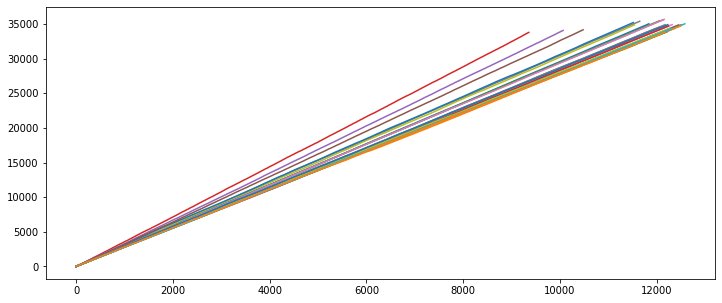

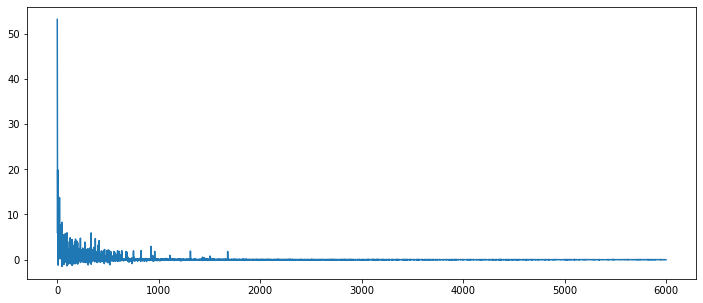

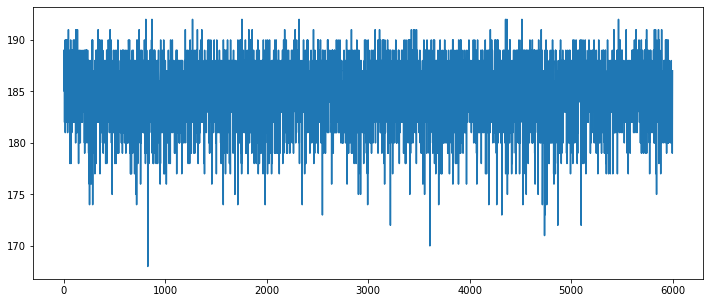

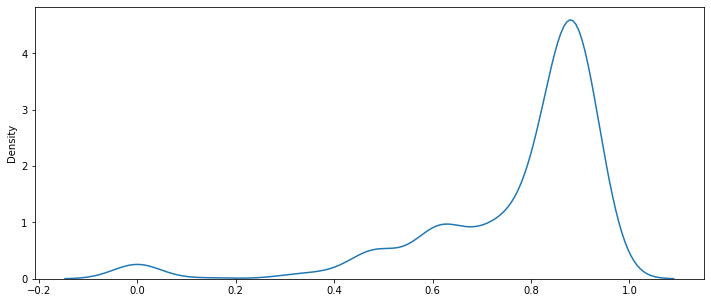

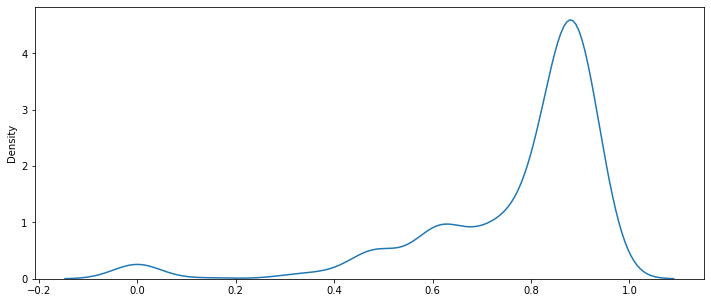

Run 2:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (20): 35753 (0.9485347836675054, CCCCCCCCCCCCDCCC)
WORST AGENT (24): 34206 (0.60416449765747, DCCCCCDCCCDCCCCC)


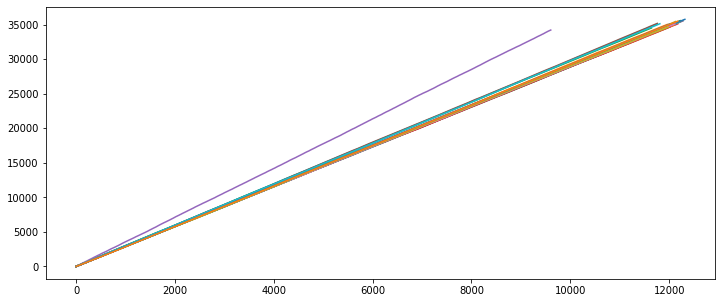

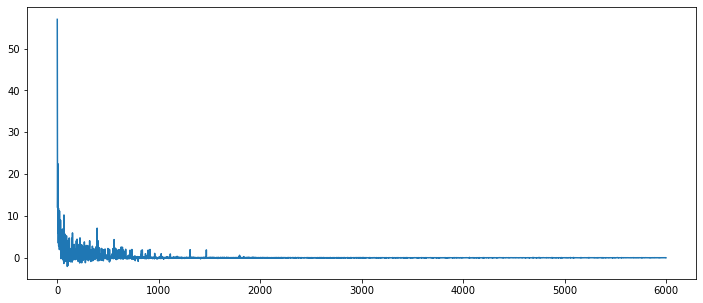

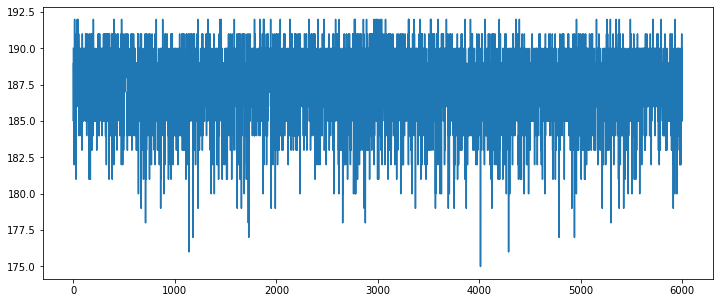

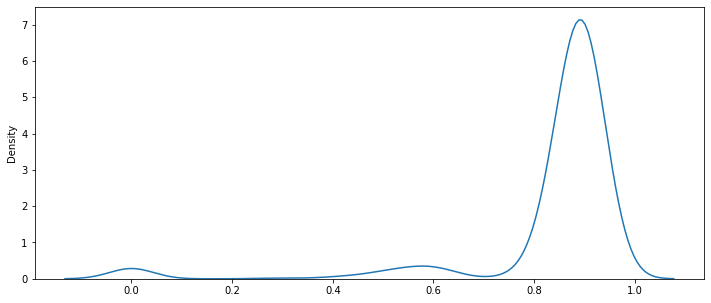

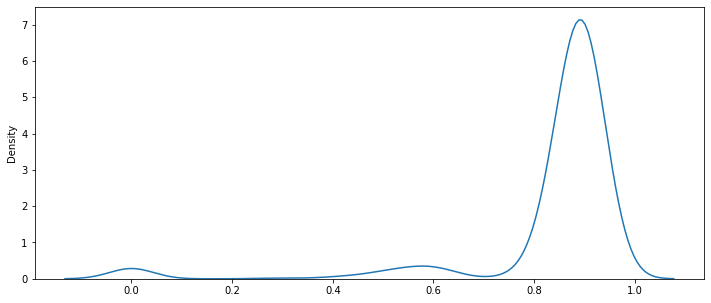

Run 3:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (27): 36514 (0.7543938711131141, CCCDCCCCDCCCCCCD)
WORST AGENT (11): 34338 (0.9522736754276179, CCCCCCCDCCCCCCCC)


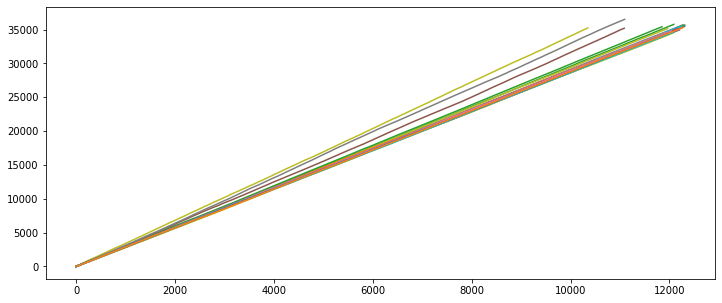

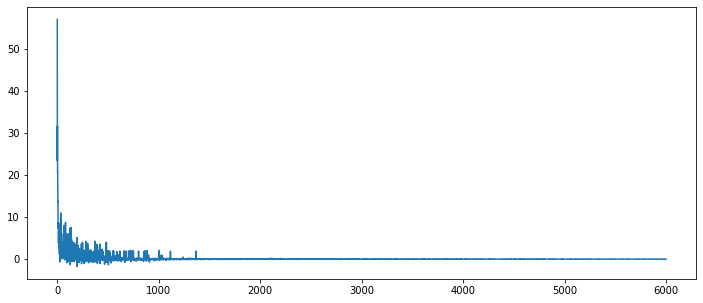

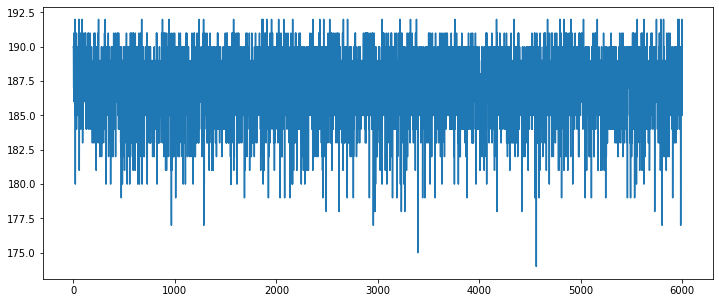

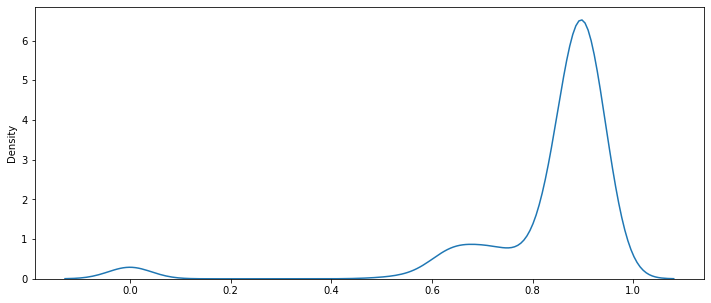

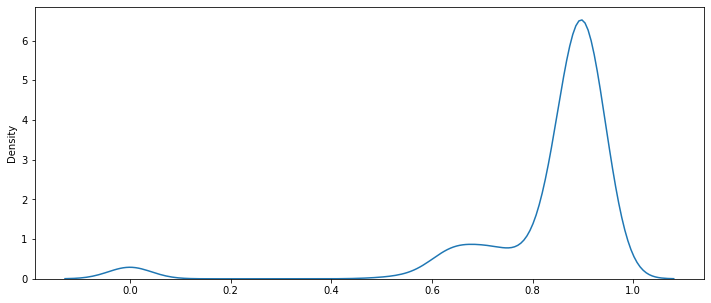

Run 4:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (12): 36600 (0.8153560266914436, CCCCCCCCDCCCCCCC)
WORST AGENT (9): 33148 (0.6996459668931203, DCCCCCCCCCCCCCCD)


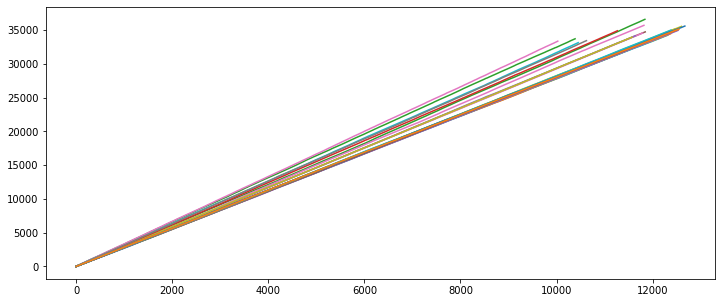

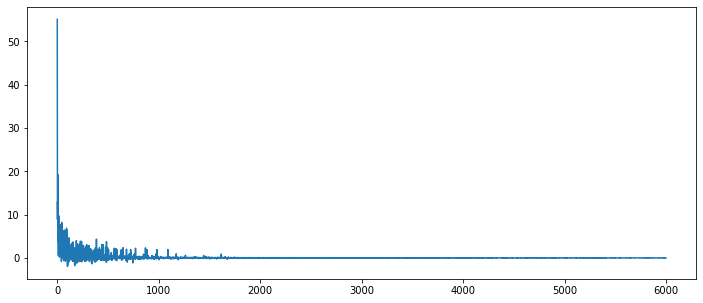

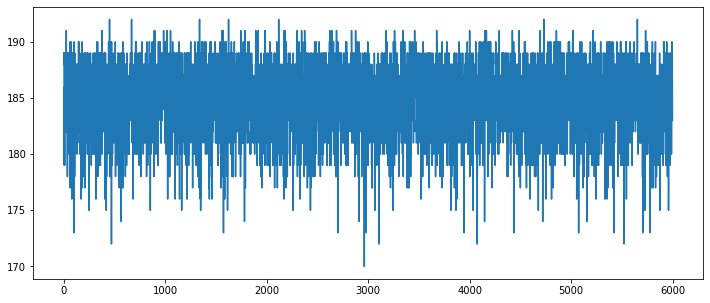

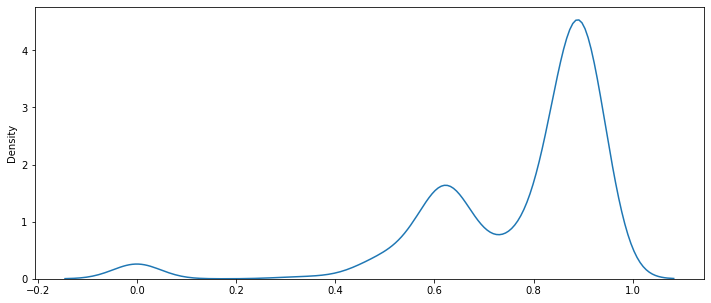

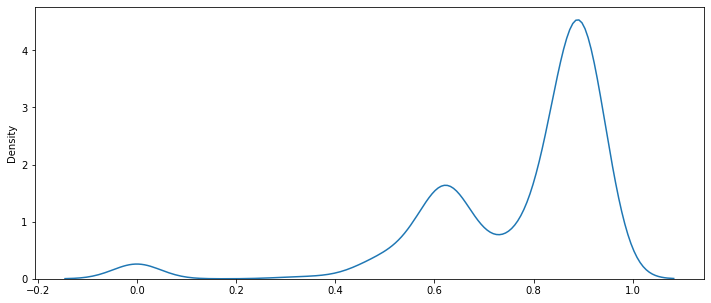

Run 5:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (18): 36964 (0.6798461400840863, CDCCDDCCDCCCCCCC)
WORST AGENT (4): 28554 (0.40052986512524086, DDDCCCCCCCDCCCDC)


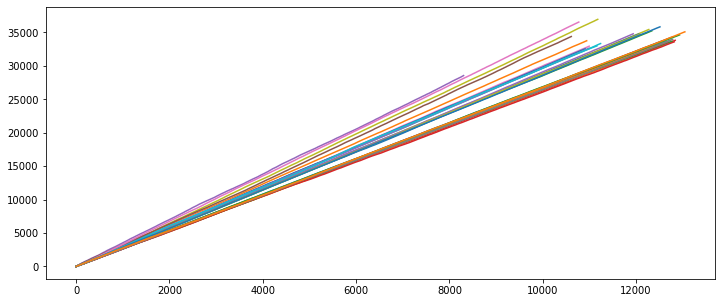

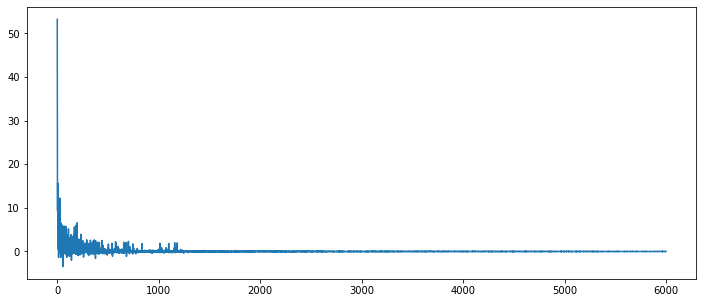

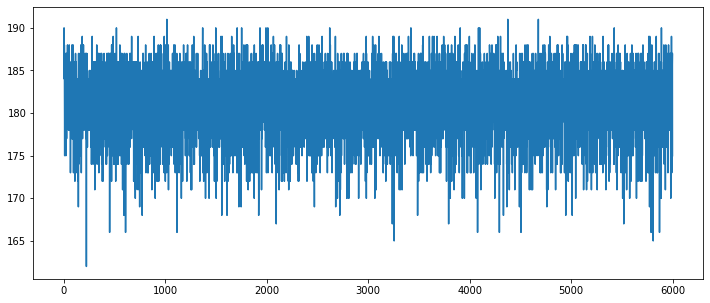

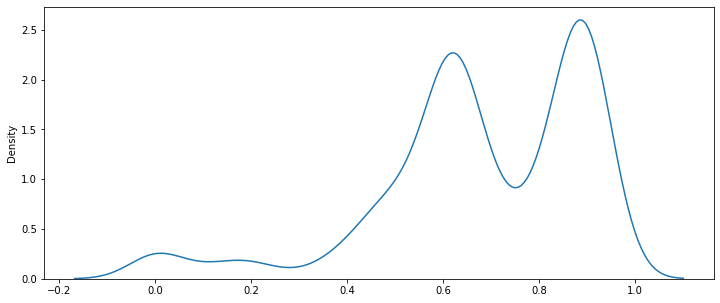

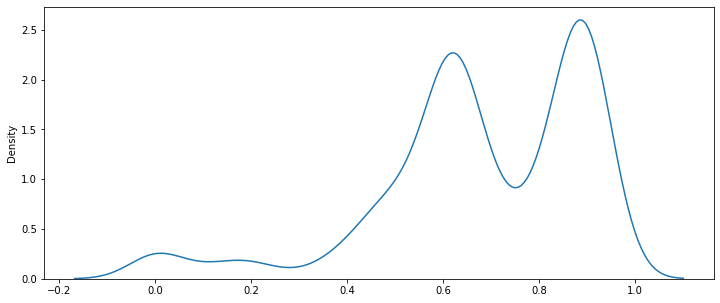

Run 6:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (5): 35892 (0.8446113149586142, CCCCCCCDDCCCCCCC)
WORST AGENT (21): 32950 (0.6974404064087534, DCCCCCCCCCCCCCCC)


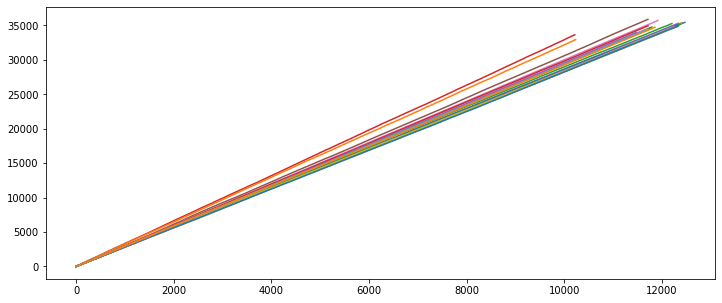

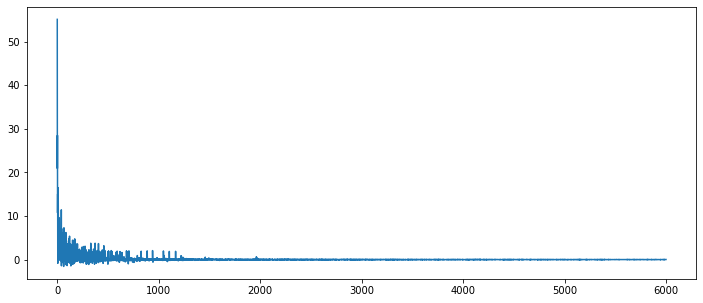

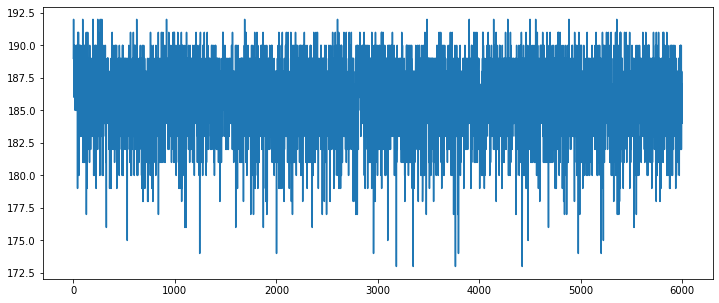

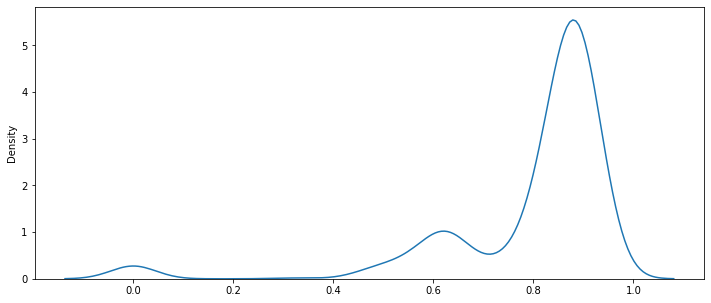

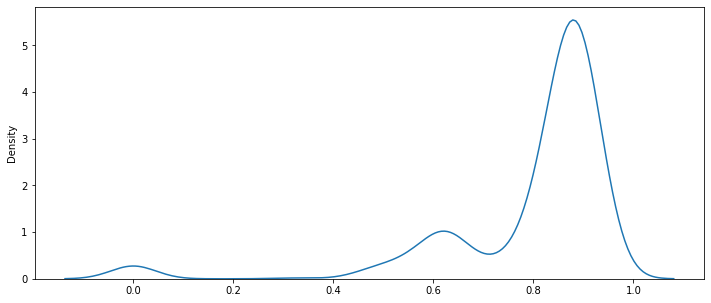

Run 7:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (19): 36759 (0.6980584285973508, CDCCDCCCDCCCCDCC)
WORST AGENT (5): 33020 (0.6238291872293282, DCCCCCDCCCDCCCCC)


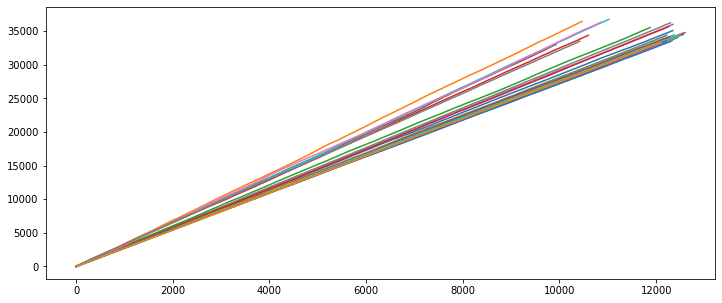

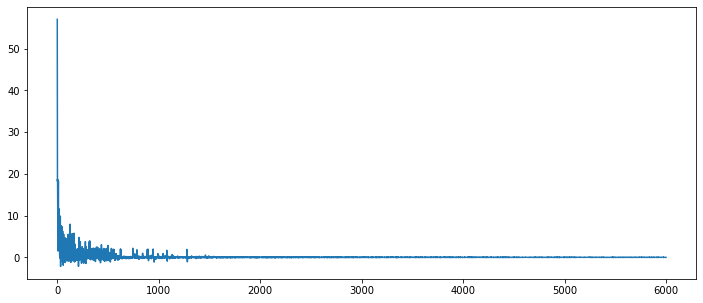

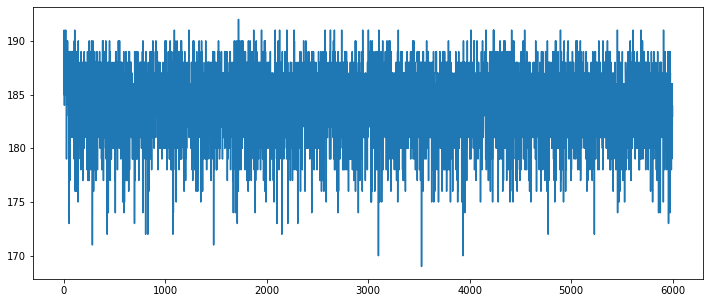

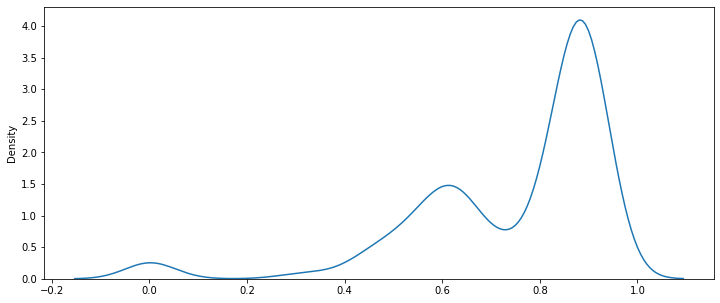

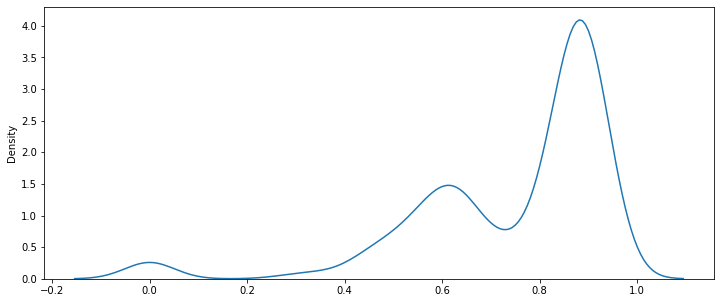

Run 8:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (9): 36586 (0.8686246775938098, CDDCCCCCCCCCCDCC)
WORST AGENT (27): 34001 (0.9514062239973373, CCCCCCCCCCCCCCCC)


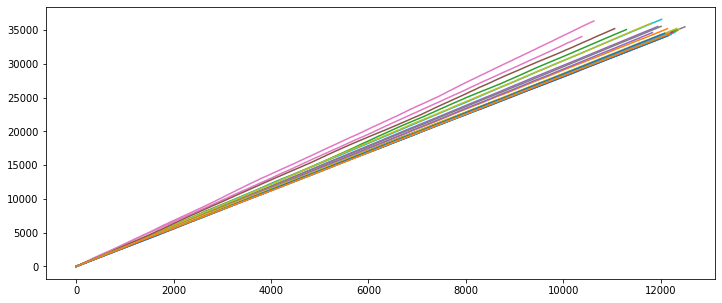

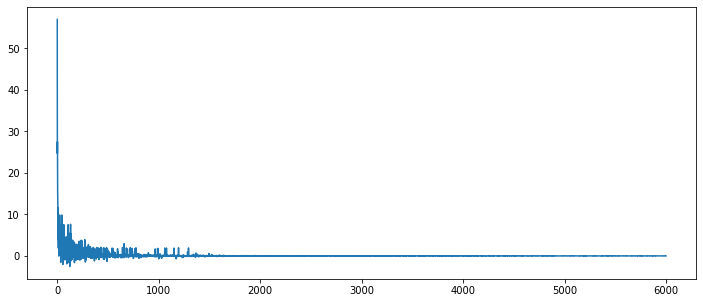

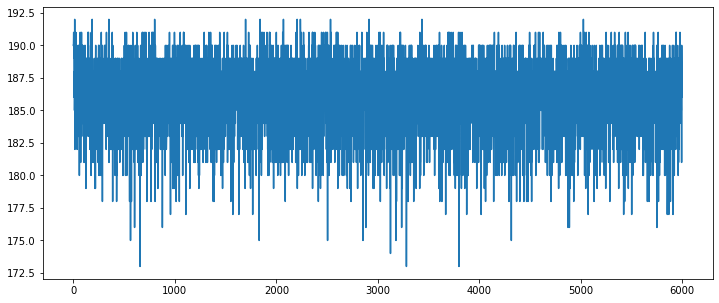

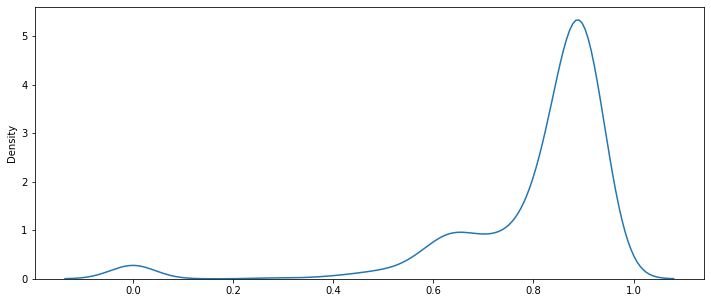

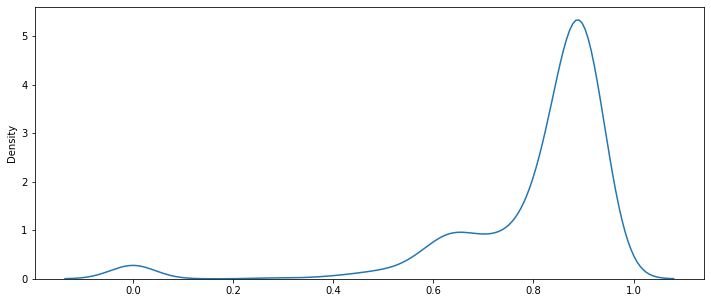

Run 9:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (17): 35616 (0.9048334585524668, CDCCCCCCCCCCCCCC)
WORST AGENT (7): 33825 (0.6752705251662862, DCCDCCCCCCCCCCCC)


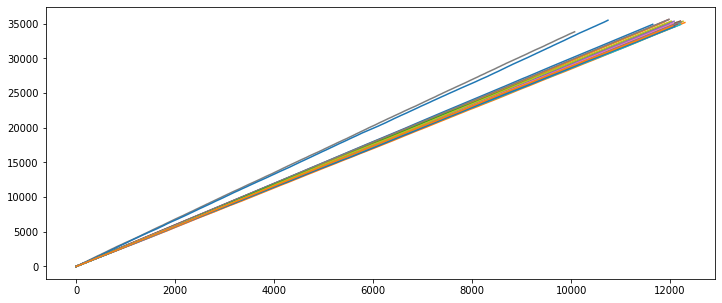

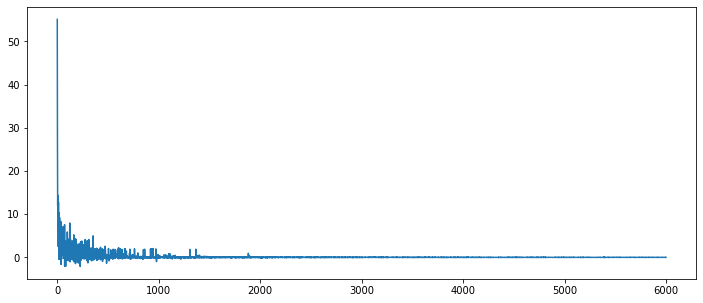

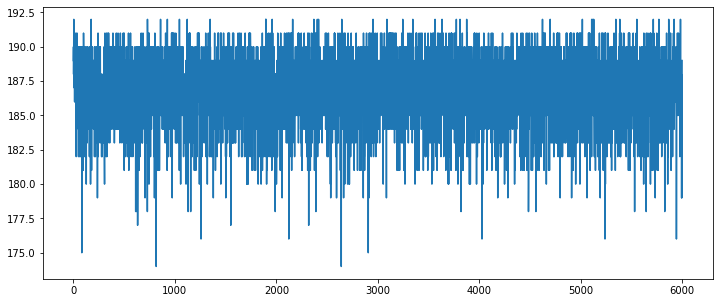

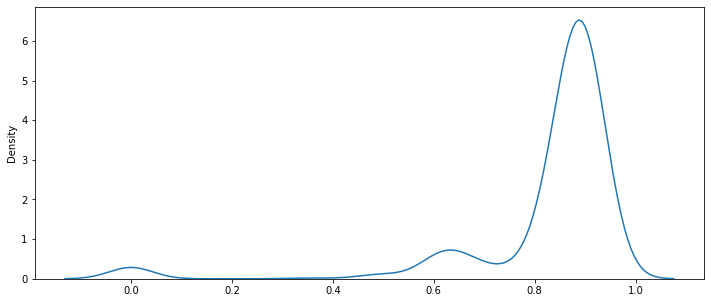

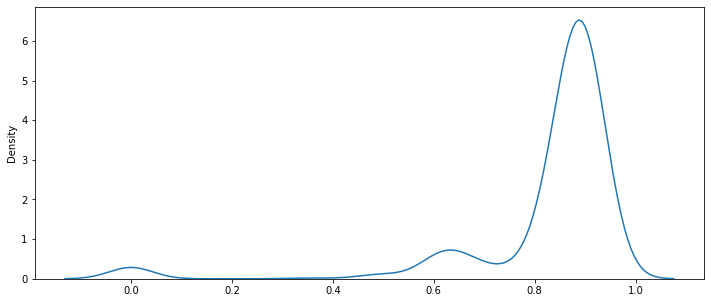

Run 10:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (15): 36060 (0.9087549277266754, CDCCCCCCCCCCCDCC)
WORST AGENT (23): 33517 (0.9465182457315032, CCCCCCDCCCCCCCCC)


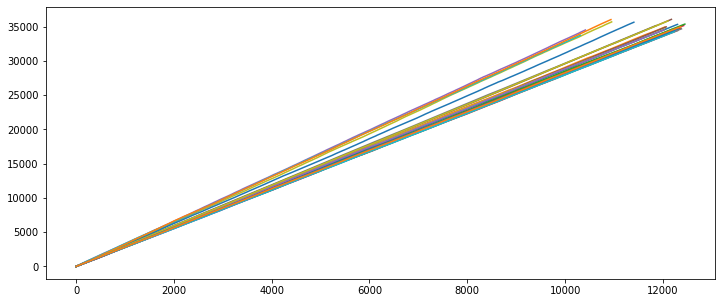

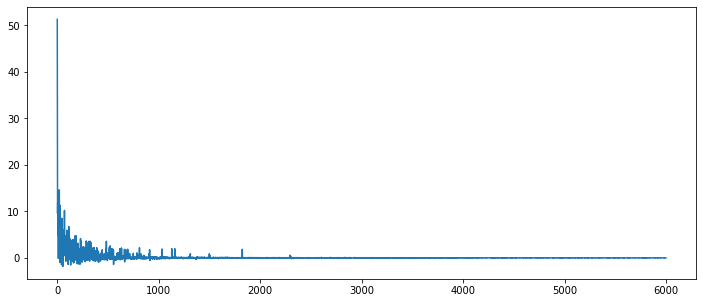

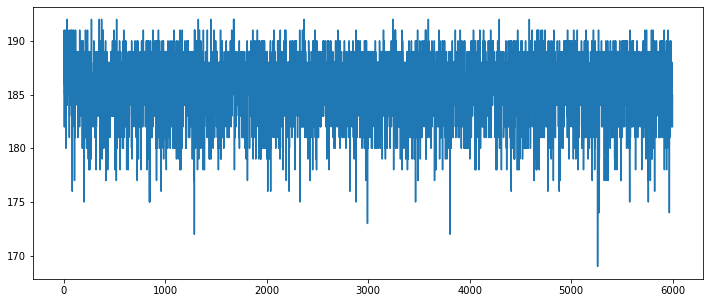

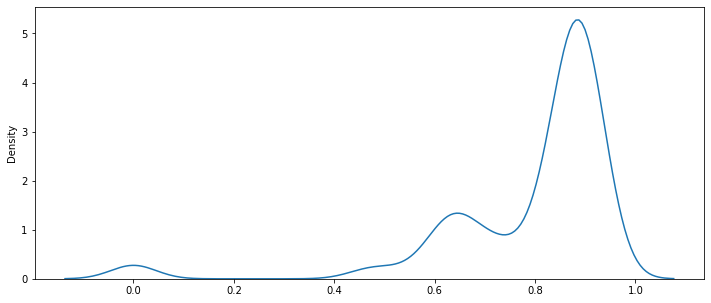

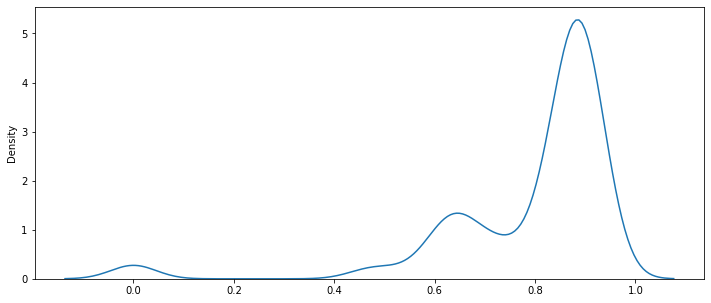

In [4]:
POPULATION = 32
ROUNDS = 6_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []
run_weights = []
run_coop = []

for run in range(10):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()

    M = sim.produce_weight_matrix()
    run_weights.append(M)

    sns.kdeplot(M.ravel())
    plt.show()

    C = sim.calculate_cooperativeness_proportions()
    run_coop.append(C)

    sns.kdeplot(C.ravel())
    plt.show()


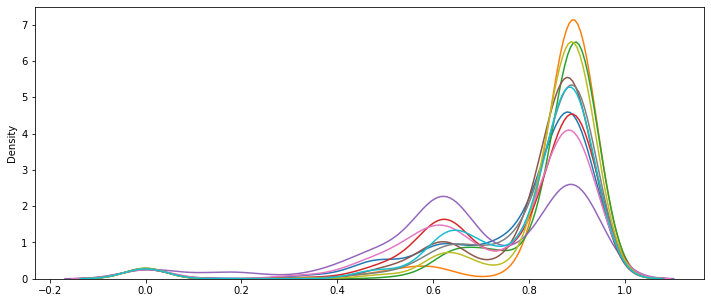

In [5]:
for w in run_weights:
    sns.kdeplot(w.ravel())

plt.show()

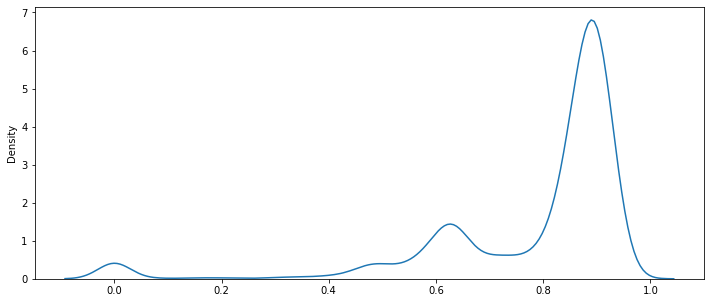

In [6]:
from itertools import chain

sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_weights])))
plt.show()

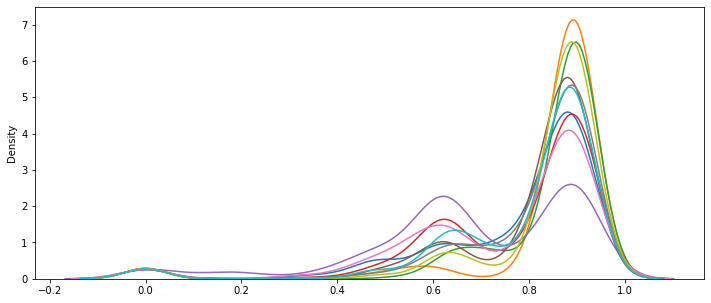

In [7]:
for w in run_coop:
    sns.kdeplot(w.ravel())

plt.show()

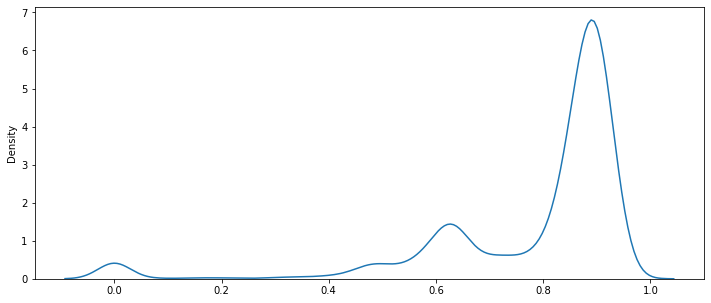

In [8]:
sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_coop])))
plt.show()

In [9]:
# G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [10]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

weights = run_weights[0]

for threshold in [0.99, 0.95, 0.9, 0.8]:
    edges = [
        (i, j, weights[i, j] + weights[j, i])
        for i in range(POPULATION)
        for j in range(i + 1, POPULATION)
        if i != j and weights[i, j] > threshold and weights[j, i] > threshold
    ]

    print(threshold, len(edges))

    # K = nx.Graph()
    # K.add_weighted_edges_from(edges)
    # nx.drawing.nx_pydot.write_dot(K, f"{dt} - {threshold} - reduced.dot")

0.99 0
0.95 0
0.9 91
0.8 333
